Here, we examine functional sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data = np.load(data_file)

# the observations
g_obs = np.array(data['g_obs'], dtype = int)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# the ground truth 
true_ind_admix_propn = data['true_ind_admix_propn']

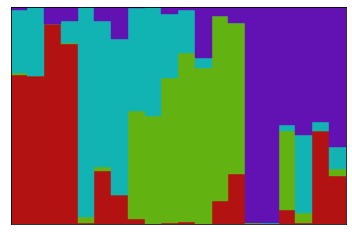

In [4]:
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

# Get prior

In [5]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [6]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [7]:
k_approx = 15

In [8]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [9]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 15, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (20, 14) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (20, 14) (lb=0.0001, ub=inf)


## Initialize 

In [10]:
vb_params_dict = \
        s_optim_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                       prior_params_dict, 
                                       gh_loc, gh_weights,
                                       seed = 34221)

AttributeError: module 'vb_lib.structure_optimization_lib' has no attribute 'set_init_vb_params'

# Optimize

In [ ]:
from vb_lib.structure_optimization_lib import define_structure_objective
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [ ]:
optim_objective, init_vb_free = \
    define_structure_objective(g_obs, vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights, 
                        compile_hvp=False)


In [11]:
out = run_lbfgs(optim_objective, init_vb_free)

vb_opt = out.x
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)


NameError: name 'run_lbfgs' is not defined

# Check out the fit

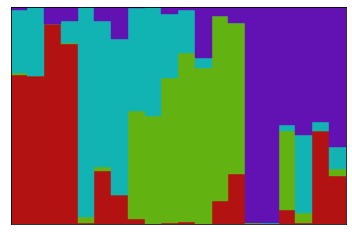

In [12]:
# truth
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

Text(0.5, 0, 'individual')

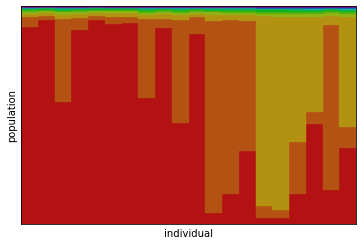

In [17]:
# estimated 

e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(e_ind_admix, axarr);

plt.ylabel('population')
plt.xlabel('individual')

# Set up linear response derivatives

In [18]:
# set up objective functions

# this just returns the KL at epsilon = 0 
# (no perturbation)
# NOTE this function doesn't actually depend on epsilon
# we can do this and set log_phi later because 
# the perturbation is multiplicative 
# (so the hessian at epsilon = 0 does not depend on the perturbation)
get_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_kl(g_obs, 
                                            params,
                                            prior_params_dict, 
                                            gh_loc,
                                            gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)


# this is just a place holder for a null perturbation
# will set this properly later
hyper_par_objective_fun = lambda params, epsilon: 0.


In [19]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = get_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        hyper_par_objective_fun = hyper_par_objective_fun)


Compiling ...
Compile time: 83.2439sec



# Compute influence function

In [21]:
# the influence function
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           epsilon_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

### Define posterior quantity of interest

In [22]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key, n_samples = 10000)

In [23]:
get_grad_g = jax.jacobian(g, argnums = 0)
grad_g = get_grad_g(vb_opt, vb_params_paragami)

### worst-case influence

In [24]:
influence_fun = lambda logit_v : np.dot(grad_g,
                                        influence_operator.get_influence(logit_v))

In [26]:
worst_case_pert = influence_lib.WorstCasePerturbation(influence_fun)

### Plot influence function

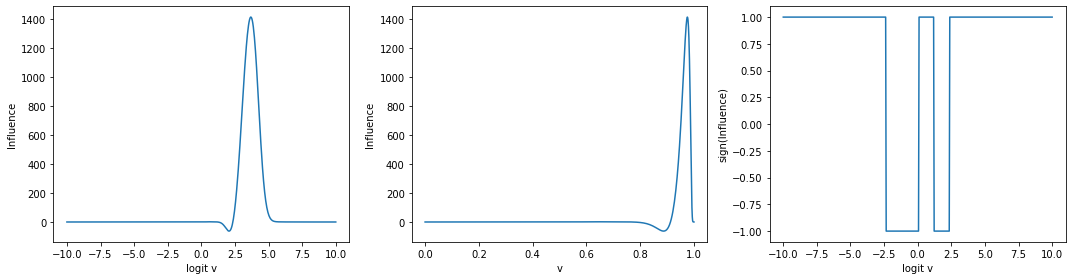

In [27]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 
ax[0].plot(worst_case_pert.logit_v_grid, worst_case_pert.influence_grid)
ax[0].set_xlabel('logit v')
ax[0].set_ylabel('Influence')

ax[1].plot(worst_case_pert.v_grid, worst_case_pert.influence_grid)
ax[1].set_xlabel('v')
ax[1].set_ylabel('Influence')

ax[2].plot(worst_case_pert.logit_v_grid, np.sign(worst_case_pert.influence_grid))
ax[2].set_xlabel('logit v')
ax[2].set_ylabel('sign(Influence)')

fig.tight_layout()

# Define prior perturbation

In [28]:
# just for plotting only! 
# saves some time in computing the influence function
# by doing a setp function interpolation
def influence_fun_interp(logit_v): 
    # find index of logit_v_grid 
    # closest (on the left) to logit_v
    indx = np.searchsorted(worst_case_pert.logit_v_grid, logit_v)
    
    # return the influence function at those points
    return worst_case_pert.influence_grid[indx]

# define log phi
def log_phi(logit_v):
    return(np.sign(influence_fun_interp(logit_v)))

In [29]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.729731e-02
  warnings.warn(


Text(0.5, 1.0, 'Priors in logit space')

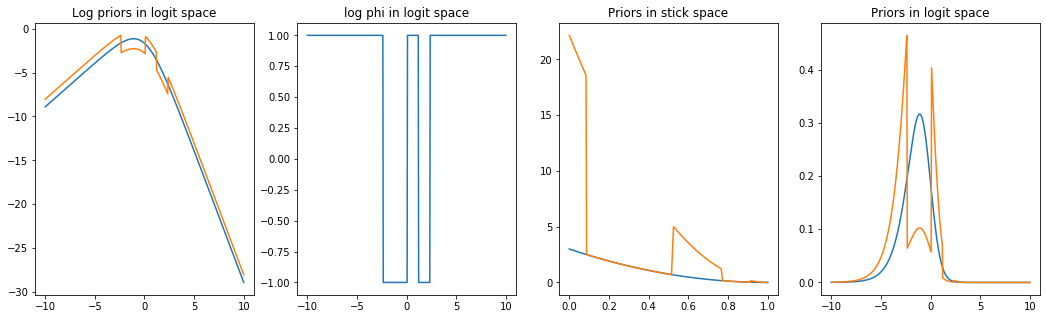

In [30]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = worst_case_pert.logit_v_grid
v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [38]:
def get_e_log_perturbation(means, infos, epsilon): 
    return epsilon * worst_case_pert.get_e_log_linf_perturbation(means.flatten(), 
                                                                 infos.flatten())

In [39]:
def _hyper_par_objective_fun(params, epsilon): 
    
    means = params['ind_admix_params']['stick_means']
    infos = params['ind_admix_params']['stick_infos']
    
    return - get_e_log_perturbation(means, infos, epsilon)

# the terms of the KL objective that depend on epsilon 
hyper_par_objective_fun = paragami.FlattenFunctionInput(_hyper_par_objective_fun,
                                                        argnums=0, 
                                                        patterns=vb_params_paragami,
                                                        free = True)


# Get derivative for prior perturbation

In [40]:
epsilon_sens._set_cross_hess(hyper_par_objective_fun)
epsilon_sens._set_dinput_dhyper()

In [41]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(lr_vb_free_params - vb_opt))

Epsilon:  1.0
Predicted differences:  26.740133172944528


In [42]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

# Re-optimize

In [43]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [46]:
optim_objective_pert, _ = \
    define_structure_objective(g_obs, new_init_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights,
                        e_log_phi = lambda means, infos : \
                                           get_e_log_perturbation(means, infos, epsilon),
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 1929.23650541
Compiling grad ...
Compile time: 11.7475secs


In [47]:
out = run_lbfgs(optim_objective_pert, new_init_free)

vb_opt_pert = out.x
vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)


Running L-BFGS-B ... 
Iter 0: f = 1929.23650541
Iter 1: f = 1918.92613145
Iter 2: f = 1920.60335444
Iter 3: f = 1903.79969551
Iter 4: f = 1890.01405614
Iter 5: f = 1872.85613734
Iter 6: f = 1859.30251600
Iter 7: f = 1853.91261335
Iter 8: f = 1850.05154876
Iter 9: f = 1847.90208291
Iter 10: f = 1846.10165255
Iter 11: f = 1843.40223701
Iter 12: f = 1841.62679578
Iter 13: f = 1840.59515860
Iter 14: f = 1840.11916434
Iter 15: f = 1839.89911600
Iter 16: f = 1839.72409184
Iter 17: f = 1839.47429993
Iter 18: f = 1839.24683555
Iter 19: f = 1838.98370669
Iter 20: f = 1838.79189110
Iter 21: f = 1838.68717646
Iter 22: f = 1838.63109252
Iter 23: f = 1838.61323877
Iter 24: f = 1838.57192042
Iter 25: f = 1838.52126571
Iter 26: f = 1838.54103490
Iter 27: f = 1838.49609605
Iter 28: f = 1838.46738431
Iter 29: f = 1838.45195099
Iter 30: f = 1838.43785934
Iter 31: f = 1838.39946361
Iter 32: f = 1838.41356076
Iter 33: f = 1838.37178762
Iter 34: f = 1838.33161459
Iter 35: f = 1838.27028513
Iter 36: f = 18

In [48]:
np.linalg.norm(vb_opt_pert - vb_opt)

DeviceArray(20.5884474, dtype=float64)

### compare

In [49]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


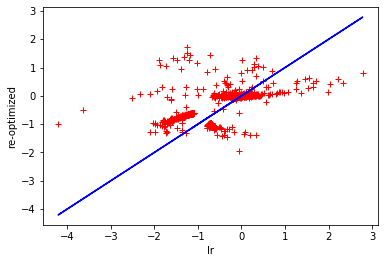

In [50]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [51]:
print('init number of cluster: ', g(vb_opt, vb_params_paragami))

print('pert number of cluster: ', g(vb_opt_pert, vb_params_paragami))
print('lr number of cluster: ', g(lr_vb_free_params, vb_params_paragami))

init number of cluster:  3.7411003422078095
pert number of cluster:  3.4294780870433663
lr number of cluster:  3.234438679004914


# Fit for a range of epsilon

In [52]:
epsilon_list = np.linspace(0, 1, 8) ** 2 # Square to get more points close to 0
print(epsilon_list)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [54]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum
    
    optim_objective_pert, new_init_free = \
        define_structure_objective(g_obs, new_init_dict,
                            vb_params_paragami,
                            prior_params_dict,
                            gh_loc = gh_loc,
                            gh_weights = gh_weights,
                            e_log_phi = lambda means, infos : \
                                           get_e_log_perturbation(means, infos, epsilon),
                            compile_hvp=False)
    
    out = run_lbfgs(optim_objective_pert, new_init_free)
        
    return out.x


In [55]:
print('epsilons: ', epsilon_list)

epsilons:  [0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [56]:
vb_pert_list = []
for epsilon in epsilon_list: 
    print('\n re-optimzing with epsilon = ', epsilon)
    
    vb_pert_list.append(refit_with_epsilon(epsilon, new_init_dict))



 re-optimzing with epsilon =  0.0
Compiling objective ...
Iter 0: f = 1830.09680291
Compiling grad ...
Compile time: 12.1212secs

Running L-BFGS-B ... 
Iter 0: f = 1830.09680291
Iter 1: f = 1832.47363604
Iter 2: f = 1830.09680172
done. Elapsed 0.081913secs
Iter 3: f = 1830.09680172
objective value:  1830.0968017205576

 re-optimzing with epsilon =  0.02040816326530612
Compiling objective ...
Iter 0: f = 1832.12006214
Compiling grad ...
Compile time: 11.8436secs

Running L-BFGS-B ... 
Iter 0: f = 1832.12006214
Iter 1: f = 1832.87166112
Iter 2: f = 1832.10662962
Iter 3: f = 1832.09806558
Iter 4: f = 1832.08937821
Iter 5: f = 1832.08166026
Iter 6: f = 1832.07836124
Iter 7: f = 1832.07648084
Iter 8: f = 1832.07614941
Iter 9: f = 1832.07535209
Iter 10: f = 1832.07522062
Iter 11: f = 1832.07502798
Iter 12: f = 1832.07494601
Iter 13: f = 1832.07483046
Iter 14: f = 1832.07469741
Iter 15: f = 1832.07475647
Iter 16: f = 1832.07463979
Iter 17: f = 1832.07457735
Iter 18: f = 1832.07454445
Iter 19

Iter 29: f = 1850.52937640
Iter 30: f = 1850.51972610
Iter 31: f = 1850.50793372
Iter 32: f = 1850.49701453
Iter 33: f = 1850.48729275
Iter 34: f = 1850.47716429
Iter 35: f = 1850.46485245
Iter 36: f = 1850.45401364
Iter 37: f = 1850.44372554
Iter 38: f = 1850.43428576
Iter 39: f = 1850.42698208
Iter 40: f = 1850.41829514
Iter 41: f = 1850.41445701
Iter 42: f = 1850.40756903
Iter 43: f = 1850.39723829
Iter 44: f = 1850.38944497
Iter 45: f = 1850.38244179
Iter 46: f = 1850.37738296
Iter 47: f = 1850.37493038
Iter 48: f = 1850.37331165
Iter 49: f = 1850.37268807
Iter 50: f = 1850.37212198
Iter 51: f = 1850.37140525
Iter 52: f = 1850.37085849
Iter 53: f = 1850.37047255
Iter 54: f = 1850.36991638
Iter 55: f = 1850.36883683
Iter 56: f = 1850.36492454
Iter 57: f = 1850.37247348
Iter 58: f = 1850.36156435
Iter 59: f = 1850.35662973
Iter 60: f = 1850.34811868
Iter 61: f = 1850.31874182
Iter 62: f = 1850.30035594
Iter 63: f = 1850.29489453
Iter 64: f = 1850.27439772
Iter 65: f = 1850.26114749
I

# Check free parameters

In [57]:
lr_list = []

for epsilon in epsilon_list: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))


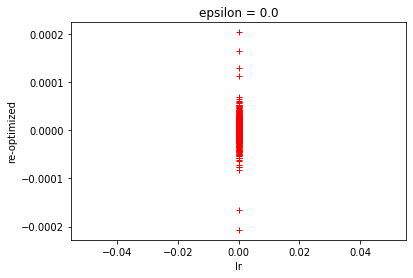

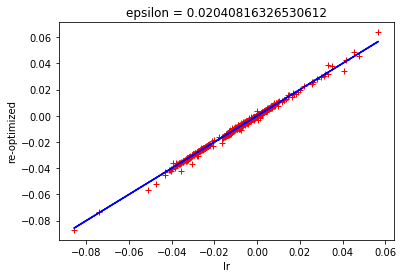

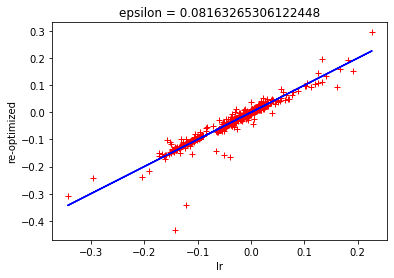

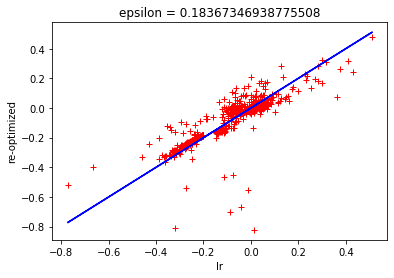

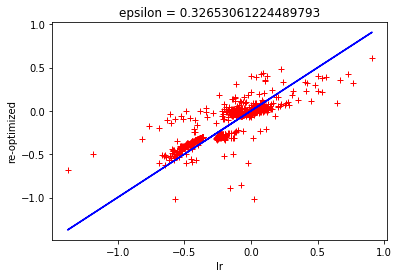

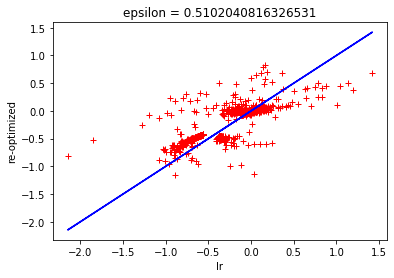

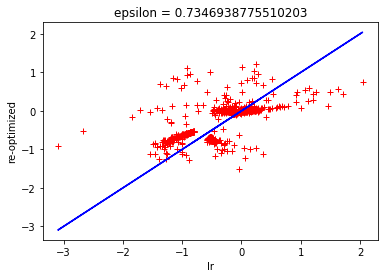

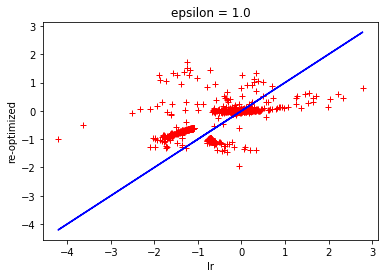

In [58]:
for i in range(len(epsilon_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('epsilon = {}'.format(epsilon_list[i]))


# Number of clusters

In [62]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_list))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_list))

for i in range(len(epsilon_list)): 
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = g(vb_pert_list[i], vb_params_paragami)
    lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)


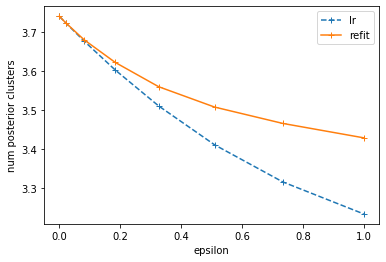

In [63]:
plt.plot(epsilon_list, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
